## K-means Clustering

在这个练习中，您将实现K-means算法并将其用于图像压缩。通过减少图像中出现的颜色的数量，只剩下那些在图像中最常见的颜色。

### Implementing K-means

#### Finding closest centroids

在K-means算法的分配簇的阶段，算法将每一个训练样本 xi分配给最接近的簇中心

$$ c^{(i)}:= j \quad that\quad minimizes ||x^{(i)} - \mu||^2 $$


c^(i)表示离样本x_i 最近的簇中心点;  
u_j是第j 个簇中心点的位置（值）

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
def find_closest_centroids(X, centroids):
    """
    output a one-dimensional array idx that holds the 
    index of the closest centroid to every training example.
    """
    idx = []
    max_dist = 1000000 # 限制最大的距离
    for i in range(len(X)):
        minus = X[i] - centroids
        dist = minus[:,0] ** 2 + minus[:,1] ** 2
        if dist.min() < max_dist:
            ci = np.argmin(dist)
            idx.append(ci)
    return np.array(idx)

In [3]:
mat = sio.loadmat('./ex7/ex7data2.mat')
# print(mat.keys())
X = mat['X']
init_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = find_closest_centroids(X, centroids=init_centroids)
idx[:3]

array([0, 2, 1], dtype=int64)

#### Computing centroid means

分配好每个点对应的簇中心，接下来要做的是，重新计算每个簇中心，为这个簇里面所有点位置的平均值。


$$ \mu_k = \frac{1}{|C_k|} \sum_{i\in C_k}{}x^{(i)} $$

C_k是我们分配好给簇中心点的样本集。

In [4]:
# np.unique: 去除其中重复的元素
def compute_centroids(X, idx):
    centroids = []
    for i in range(len(np.unique(idx))):
        u_k = X[np.where(idx==i)].mean(axis=0)
        centroids.append(u_k)
    return np.array(centroids)

In [5]:
compute_centroids(X, idx)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

### K-means on example dataset

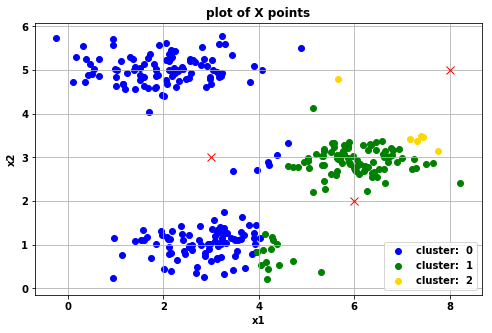

In [6]:
def plot_data(X, centroids, indx=None):
    colors = ['b','g','gold','darkorange','salmon','olivedrab', 
              'maroon', 'navy', 'sienna', 'tomato', 'lightgray', 'gainsboro'
             'coral', 'aliceblue', 'dimgray', 'mintcream', 'mintcream']
    assert len(centroids[0]) <= len(colors), 'colors not enough'
    subX = [] # 分类号的样本点
    if idx is not None:
        for i in range(centroids[0].shape[0]):
            x_i = X[idx==i]
            subX.append(x_i)
    else:
        subX = [X] # 将X转化为一个元素的列表，每个元素为每个簇的样本集
    # 分别画出每个簇的点，并着不同的颜色
    plt.figure(figsize=(8,5))
    for i in range(len(subX)):
        xx = subX[i]
        plt.scatter(xx[:,0], xx[:,1], c=colors[i], label='cluster: % d' % i)
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('plot of X points')
    plt.grid(True)
    plt.legend()
    
    # 画出簇中心的移动轨迹
    xx, yy = [],[]
    for centroid in centroids:
        xx.append(centroid[:,0])
        yy.append(centroid[:,1])
    plt.plot(xx, yy, 'rx--', markersize=8)
    
plot_data(X, [init_centroids])

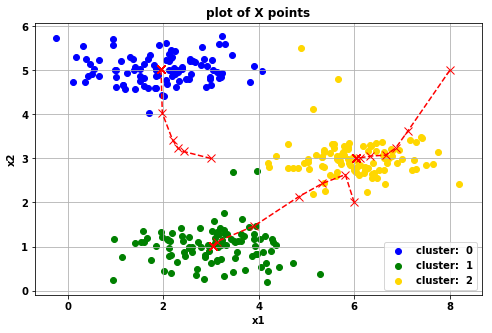

In [7]:
def run_kmeans(X, centroids, max_iters):
    K = len(centroids)
    
    centroids_all = []
    centroids_all.append(centroids)
    centroid_i = centroids
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroid_i)
        centroid_i = compute_centroids(X, idx)
        centroids_all.append(centroid_i)
    return idx, centroids_all
idx, centroids_all = run_kmeans(X, init_centroids, 20)
plot_data(X, centroids_all, idx)

### Random initialization

在实践中，对簇中心点进行初始化的一个好的策略就是从训练集中选择随机的例子。

In [8]:
def init_centroids(X, k):
    """随机初始化"""
    m,n = X.shape
    idx = np.random.choice(m,k)
    centroids = X[idx]
    return centroids

进行三次随机初始化，看下各自的效果。会发现前面两次的效果并不理想，这是正常的，落入了局部最优。

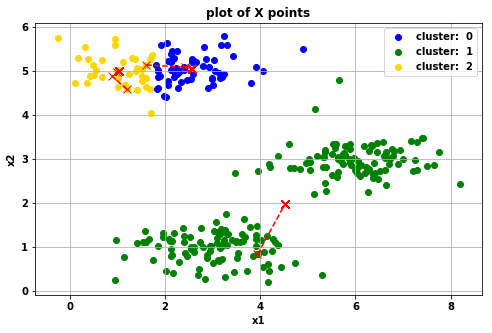

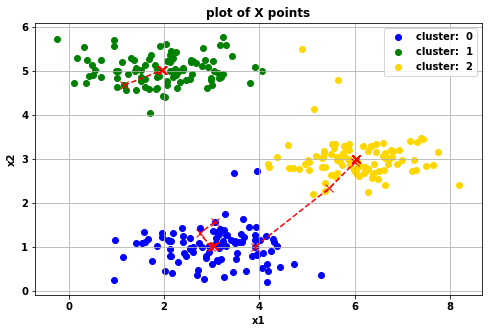

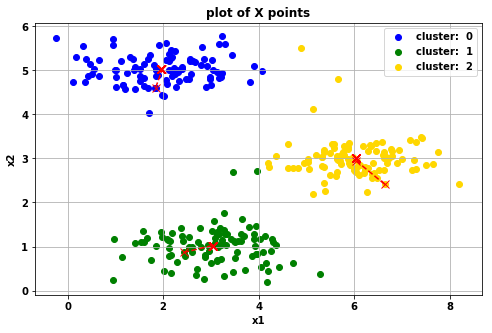

In [9]:
for i in range(3):
    centroids = init_centroids(X, 3)
    idx, centroids_all = run_kmeans(X, centroids, 20)
    plot_data(X, centroids_all, idx)

上面运行了三次随机初始化，可以看到不同的随机化，效果是不一样的。

### Image compression with K-means

这部分你将用Kmeans来进行图片压缩。在一个简单的24位颜色表示图像。每个像素被表示为三个8位无符号整数(从0到255)，指定了红、绿和蓝色的强度值。这种编码通常被称为RGB编码。我们的图像包含数千种颜色，在这一部分的练习中，你将把颜色的数量减少到16种颜色。

这可以有效地压缩照片。具体地说，您只需要存储16个选中颜色的RGB值，而对于图中的每个像素，现在只需要将该颜色的索引存储在该位置(只需要4 bits就能表示16种可能性)。

接下来我们要用K-means算法选16种颜色，用于图片压缩。你将把原始图片的每个像素看作一个数据样本，然后利用K-means算法去找分组最好的16种颜色。


#### K-means on pixels

In [10]:
from skimage import io

(128, 128, 3)


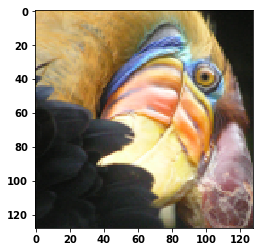

In [11]:
A= io.imread('./ex7/bird_small.png')
print(A.shape)
plt.imshow(A)
A = A/255 # Divide by 255 so that all values are in the range 0 - 1

In [12]:
X = A.reshape(-1, 3)
X.shape

(16384, 3)

In [14]:
#  Reshape the image into an (N,3) matrix where N = number of pixels.
#  Each row will contain the Red, Green and Blue pixel values
#  This gives us our dataset matrix X that we will use K-Means on

K = 16
centroids = init_centroids(X, K)
idx, centroids_all = run_kmeans(X, centroids, 10)

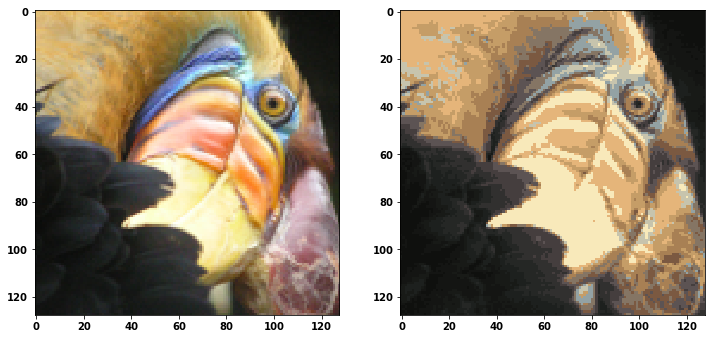

In [15]:
img = np.zeros(X.shape)
centroids = centroids_all[-1]
for i in range(len(centroids)):
    img[idx==i] = centroids[i]
    
img = img.reshape((128,128,3))
fig ,axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(A)
axes[1].imshow(img)

## Principal Component Analysis

这部分，你将运用PCA来实现降维。您将首先通过一个2D数据集进行实验，以获得关于PCA如何工作的直观感受，然后在一个更大的图像数据集上使用它。

在这部分练习中，您将看到使用PCA将数据从2D减少到1D时会发生什么。

In [17]:
data2 = sio.loadmat('./ex7/ex7data1.mat')
X = data2['X']
X.shape

(50, 2)

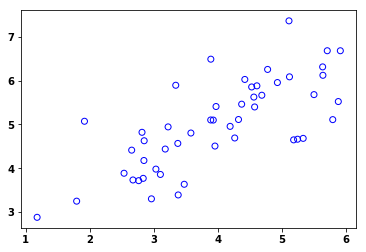

In [19]:
plt.scatter(X[:,0],X[:,1], facecolors='none', edgecolors='b')

### Implementing PCA

PCA由两部分组成：
+ 计算数据的方差矩阵
+ 用SVD计算特征向量(U1,U2,...,Un)

在PCA之前，记得标准化数据。

然后计算方差矩阵，如果你的每条样本数据是以行的形式表示，那么计算公式如下：


$$ \sum_{}^{} = \frac{1}{m}X^TX $$

接着就可以用SVD计算主成分

[U, S, V] = svd(Sigma)

U包含了主成分，每一列就是我们数据要映射的向量，S为对角矩阵，为奇异值

In [23]:
def feature_normalize(X):
    """均值归一化"""
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0, ddof=1) # ddof表示样本标准差
    X_norm = (X - means) /stds
    return X_norm, means, stds

由于我们的协方差矩阵为X.T@X, X中每行为一条数据，我们是想要对列(特征)做压缩。

这里由于是对协方差矩阵做SVD(), 所以得到的入口基其实为 V‘，出口基为V，可以打印出各自的shape来判断。

故我们这里是对 数据集的列 做压缩。

SVD原理参考：https://www.cnblogs.com/pinard/p/6251584.html

In [24]:
def pca(X):
    sigma = (X.T @ X) / len(X)
    U, S, V = np.linalg.svd(sigma)
    return U, S, V

[-0.70710678 -0.70710678]


(0.9352314030578326, 6.156300248189644, 2.642327687079511, 7.599563030370963)

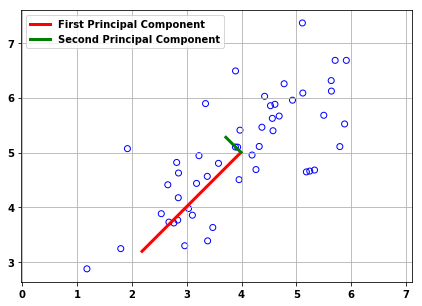

In [26]:
X_norm, means, stds = feature_normalize(X)
U, S, V = pca(X_norm)

print(U[:,0])

plt.figure(figsize=(7,5))
plt.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='b')

plt.plot([means[0], means[0] + 1.5*S[0]*U[0,0]],
        [means[1], means[1] + 1.5*S[0]*U[0,1]],
        c='r',linewidth=3, label='First Principal Component')
plt.plot([means[0], means[0] + 1.5*S[1]*U[1,0]],
        [means[1], means[1] + 1.5*S[1]*U[1,1]],
        c='g', linewidth=3, label='Second Principal Component')
plt.grid(True)
plt.legend()
plt.axis('equal')

### Dimensionality Reduction with PCA

#### Projecting the data onto the principal components

In [27]:
U.shape

(2, 2)

In [28]:
def project(X, U, K):
    Z = X @ U[:,:K]
    return Z

In [31]:
# project the first example onto the first dimension 
# and you should see a value of about 1.481
Z = project(X_norm, U, 1)
Z[0]

array([1.48127391])

#### Reconstructing an approximation of the data

In [35]:
def recover_data(Z, U, K):
    X_appro = Z @ U[:,:K].T
    return X_appro

In [36]:
# you will recover an approximation of the first example and you should see a value of
# about [-1.047 -1.047].
X_appro = recover_data(Z, U, 1)
X_appro[0]

array([-1.04741883, -1.04741883])

#### Visualizing the projections

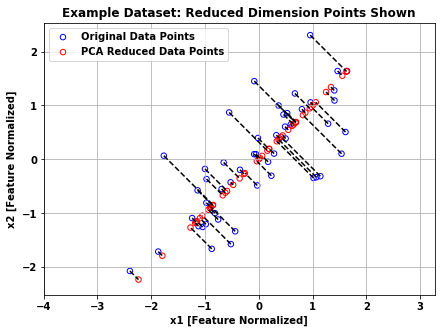

In [39]:
plt.figure(figsize=(7,5))
plt.axis('equal')
plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', edgecolors='b', label='Original Data Points')
plt.scatter(X_appro[:,0], X_appro[:,1], s=30, facecolors='none', edgecolors='r',label='PCA Reduced Data Points')

plt.title("Example Dataset: Reduced Dimension Points Shown")
plt.xlabel('x1 [Feature Normalized]')
plt.ylabel('x2 [Feature Normalized]')

for x in range(X_norm.shape[0]):
    plt.plot([X_norm[x,0], X_appro[x,0]],[X_norm[x,1], X_appro[x,1]],'k--')
plt.grid(True)
plt.legend()

### Face Image Dataset

In [40]:
data3 = sio.loadmat('./ex7/ex7faces.mat')
X = data3['X']
X.shape

(5000, 1024)

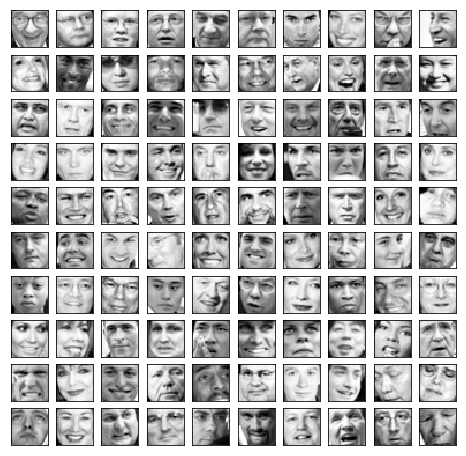

In [61]:
def display_data(X, row, col):
    fig, ax = plt.subplots(row, col, figsize=(8,8))
    for r in range(row):
        for c in range(col):
            ax[r][c].imshow(X[r*col+c].reshape(32,32).T, cmap = 'Greys_r')
            ax[r][c].set_xticks([])
            ax[r][c].set_yticks([])
display_data(X, 10, 10)

#### PCA on Faces

In [50]:
X_norm, means, stds = feature_normalize(X)

U, S, V = pca(X_norm)
U.shape, X.shape

((1024, 1024), (5000, 1024))

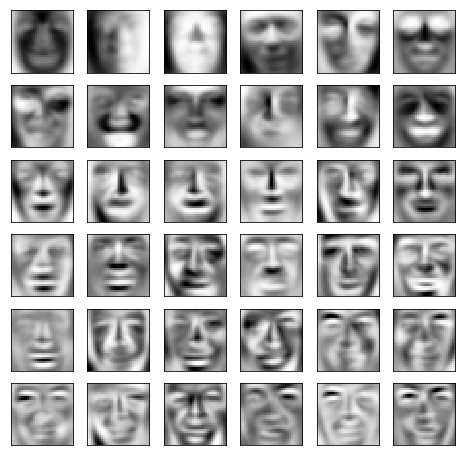

In [64]:
display_data(U[:,:36].T, 6, 6)

#### Dimensionality Reduction

((5000, 36), (5000, 1024))

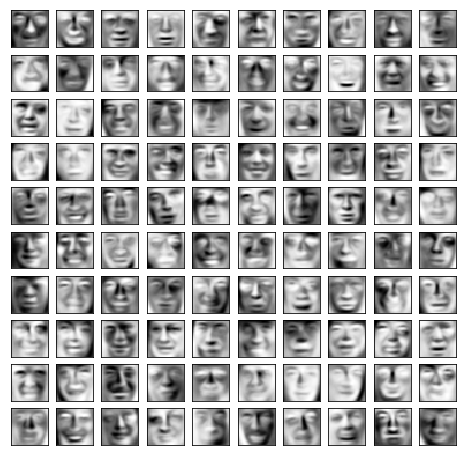

In [65]:
z = project(X_norm, U, K=36)
x_appro = recover_data(z, U, K=36)
display_data(x_appro, 10, 10)
z.shape, x_appro.shape